In [2]:
from typing import Dict, Tuple
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.utils import save_image, make_grid
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np
from IPython.display import HTML
import rasterio
from rasterio.plot import show
from PIL import Image
import os
import skimage as ski
from skimage import io
io.use_plugin('pil')
from skimage.metrics import structural_similarity as ssim

In [3]:
def convert_to_grayscale(image):
    img_final = np.zeros((1,image.shape[1],image.shape[2]))
    img_final[0,:,:] = image[0,:,:]+image[1,:,:]+image[2,:,:]
    return img_final

In [4]:

def normalize_images(images):
    min_value = np.min(images)
    max_value = np.max(images)
    normalized_images = (images - min_value) / (max_value - min_value)
    return normalized_images


In [5]:
def make_it_gray(img):
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if(img[i][j]==0):
                img[i][j]=0.5
            else:
                img[i][j]=0
    return img

In [6]:
def subsample(img, k):
    lst = []
    for i in range(0,img.shape[0]):
        x = img[i][::k, ::k]
        lst.append(x.T)
    return np.array(lst)

In [7]:
dataset = []


folder_path = "/home/rounak/Desktop/LabeledData"
image_files = [file for file in os.listdir(folder_path) if file.endswith(('.tiff'))]
k=0
image_files.sort()
for j in range(10):
    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        if(k%100==0):
            print(k)
        k+=1
        img_push = np.zeros((323,323,3))
        img = io.imread(image_path, plugin='pil')
        img = np.array(img)
        img_push[:,:,0] = normalize_images(img[:,:,0])
        img_push[:,:,1] = normalize_images(img[:,:,2])
        img_push[:,:,2] = normalize_images(img[:,:,0])*0.5+normalize_images(img[:,:,2])*0.5
        img_push = np.array(img_push)
        image_array = img_push.T
        dataset.append((torch.from_numpy(image_array),0))

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800


In [1]:
dataset = []


folder_path = "/home/rounak/Desktop/LabeledData"
image_files = [file for file in os.listdir(folder_path) if file.endswith(('.tiff'))]
k=0
image_files.sort()
for j in range(10):
    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        if(k%100==0):
            print(k)
        k+=1
        img_push = np.zeros((323,323,3))
        img = io.imread(image_path, plugin='pil')
        img = np.array(img)
        img_push[:,:,0] = normalize_images(img[:,:,0])
        img_push[:,:,1] = normalize_images(img[:,:,2])
        img_push[:,:,2] = normalize_images(img[:,:,0])*0.5+normalize_images(img[:,:,2])*0.5
        img_push = np.array(img_push)
        image_array = img_push.T
        dataset.append((torch.from_numpy(np.expand_dims(np.float32(img[:,:,0]),axis=0)),0))

NameError: name 'os' is not defined

In [9]:
folder_path = "/home/rounak/Desktop/LabeledData"
image_files = [file for file in os.listdir(folder_path) if file.endswith(('_mask.png'))]
image_files.sort()
k=0
dataset_mask = []
for j in range(10):
    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        if(k%100==0):
            print(k)
        k+=1
        img = io.imread(image_path, plugin='pil')
        dataset_mask.append(img)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800


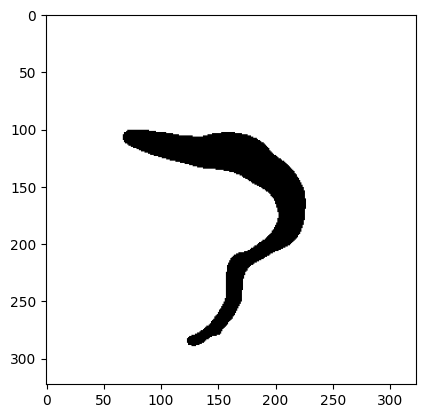

In [10]:
i = 0
x = np.array(dataset[i][0][0,:,:].T)
y = np.array(dataset_mask[i])/255
final = normalize_images(np.multiply(x,y))
y1 = make_it_gray(y)
final = normalize_images(final+y1)
plt.imshow(y, cmap="gray")

In [11]:
dataset_final = []
for i in range(1870):
    if(i%100==0):
        print(i)
    x = np.array(dataset[i][0][0,:,:].T)
    y = np.array(dataset_mask[i])/255
    final = normalize_images(np.multiply(x,y))
    y1 = make_it_gray(y)
    final = normalize_images(final+y1)
    final = np.expand_dims(final, axis=0)
    dataset_final.append((final ,0))

0


KeyboardInterrupt: 

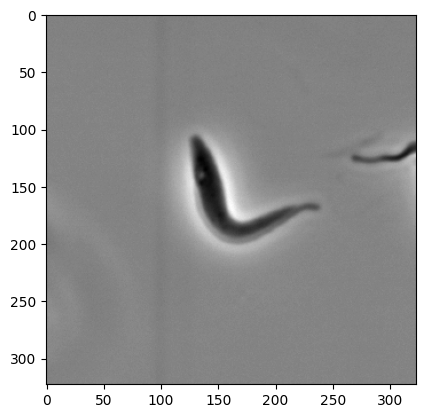

In [14]:
i=np.random.randint(1000)
plt.imshow(dataset[i][0].T, cmap="gray")

In [11]:
x_train = []
for i in range(1870):
    x_train.append(np.array(dataset[i][0].T))
x_train_1 = []
for i in range(1870):
    x_train_1.append(np.array(dataset[i][0][:,:316,:316].T))

/tmp/ipykernel_946916/2974727832.py:3: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3571.)
  x_train.append(np.array(dataset[i][0].T))


In [12]:
x_train = np.array(x_train)
x_train.shape

(1870, 323, 323, 3)

In [13]:
x_train_1 = np.float32(np.array(x_train_1))
x_train_1.shape

(1870, 316, 316, 3)

In [14]:
def stochastic_mixer(img1, img2, t, k):
    noise_1 = torch.randn_like(img1)
    noise_2 = torch.randn_like(img2)
    img1_encode = perturb_input(img1, t, noise_1)
    img2_encode = perturb_input(img2, t, noise_2)
    img1_vec = np.reshape(img1, (-1, 1))
    img2_vec = np.reshape(img2, (-1, 1))
    theta = np.arccos(np.matmul(img1_vec.T, img2_vec))/np.linalg.norm(img1_vec)*np.linalg.norm(img2_vec)
    img_inter_ddim = np.sin(k*theta)/np.sin(theta)*img1_encode + np.sin((1-k)*theta)/np.sin(theta)*img2_encode
    return img_inter_ddim       # create other dot products
    

def interpolator(img1, img2, t_1 = timesteps*0.7, k=0.5):
    sample = stochastic_mixer(img1, img2, t, k)
    t = torch.tensor(t_1 / timesteps).to(device)
    z = torch.randn_like(sample) if i > 1 else 0
    eps = nn_model(samples, t)
    sample = denoise_add_noise(sample, t_1, eps, z)
    return sample

def image_value(img):
    value=0
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            value+=img[i][j]
    return value


NameError: name 'timesteps' is not defined

In [ ]:
import keras
from keras import layers
import tensorflow as tf

input_img = keras.Input(shape=(320, 320, 1))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train_1,
                epochs=50,
                batch_size=128,
                shuffle=True)

In [100]:
dataset[0][0].shape

torch.Size([1, 323, 323])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


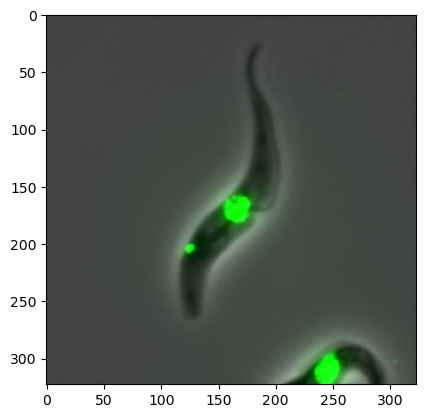

In [123]:
plt.imshow(dataset[40][0].T, cmap="gray")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


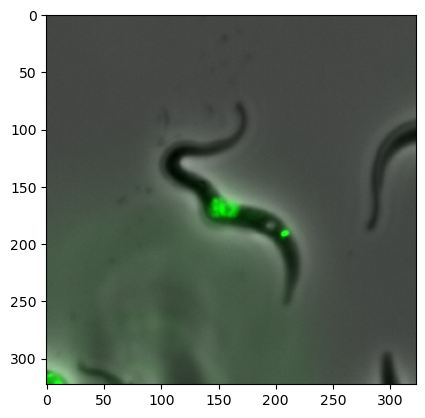

In [124]:
i=np.random.randint(300)
plt.imshow(dataset[i][0].T)

In [15]:
lst_img = []

for i in range(50):
    lst_img.append(np.array(dataset_final[i][0].T))

lst_img = np.array(lst_img)

In [16]:
lst_img.shape

(50, 323, 323, 1)

In [20]:
lst_of_img_reduced = []
loss_lst = []

lst_of_img_damn = None
for i in range(1,30):
    loss_lst.append(0)
for k in range(1,30):
    lst_of_img_damn = subsample(lst_img, k)
    latest_img = torch.from_numpy(lst_of_img_damn).float()
    img_interpolated = F.interpolate(latest_img,(323,323), mode='bilinear')
    for i in range(dataset[0][0].shape[0]):
        img = lst_img[i]
        img_int = img_interpolated[i].T
        diff_img = np.array(img)- np.array(img_int)
        ssim_none = ssim(np.squeeze(np.array(img)), np.squeeze(np.array(img_int)))
        loss_lst[k-1]+=ssim_none

TypeError: unsupported operand type(s) for *: 'float' and 'type'

In [34]:
img_interpolated.shape

torch.Size([50, 1, 323, 323])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Text(0, 0.5, 'SSIM')

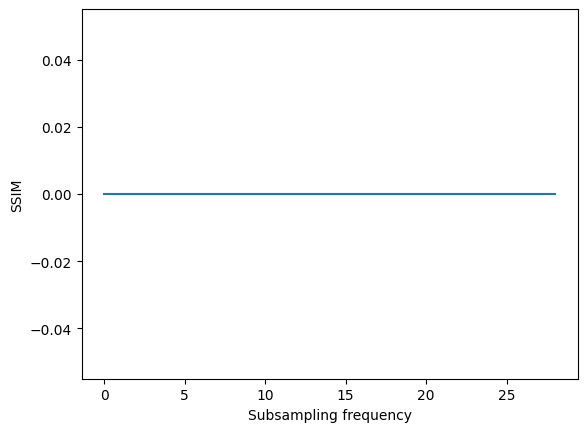

In [35]:
print(np.array(loss_lst))
plt.plot(np.array(loss_lst)/3)
plt.xlabel("Subsampling frequency")
plt.ylabel("SSIM")

In [17]:
dataset_compressed = []

for i in range(1870):
    dataset_compressed.append(np.float32(np.array(dataset[i][0].T)))
    if(i%100==0):
        print(i)
dataset_compressed = np.array(dataset_compressed)

dataset_compressed = subsample(dataset_compressed, 4)

dataset_compressed = np.array(dataset_compressed)

dataset_compressed.shape

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800


(1870, 1, 81, 81)

In [18]:
dataset_compressed = normalize_images(np.float32(np.array(dataset_compressed)))
dataset_compressed.shape

(1870, 1, 81, 81)

In [19]:
dataset_final_1 = []
for i in range(1870):
    img_arr = dataset_compressed[i]
    img_arr = img_arr[:, :80, :80]
    dataset_final_1.append((torch.from_numpy(img_arr),0))


In [20]:
np.random.shuffle(dataset_final_1)

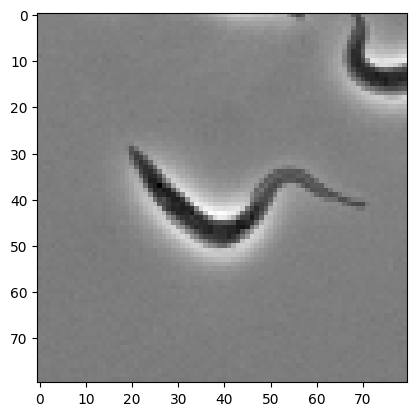

In [21]:
plt.imshow(dataset_final_1[176][0].T, cmap="gray")

In [274]:
class RotNet(nn.Module):
    def __init__(in_channels = 1, shape=80, n_angles=360):
        super(RotNet, self).__init__()
        self.in_channels = in_channels
        self.n_angles = n_angles
        self.shape = shape
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, 3, 1, 1),
            nn.BatchNorm2d(in_channels),
            nn.ReLu(),
            nn.MaxPool2d()
        )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


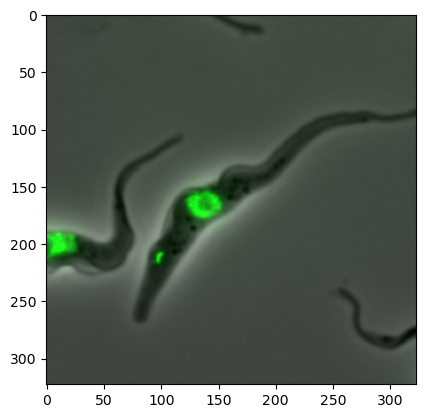

In [280]:
plt.imshow(dataset[10][0].T)

In [22]:
class ResidualConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, is_res: bool = False) -> None:
        super().__init__()
        self.same_channels = in_channels == out_channels
        self.is_res = is_res
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels), 
            nn.GELU(), 
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.is_res:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            if self.same_channels:
                out = x + x2
            else:  
                shortcut = nn.Conv2d(x.shape[1], x2.shape[1], kernel_size=1, stride=1, padding=0).to(x.device)
                out = shortcut(x) + x2
            return out / 1.414
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2

In [23]:
class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()
        layers = [ResidualConvBlock(in_channels, out_channels), nn.MaxPool2d(2)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels), 
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        return self.model(torch.cat((x, skip), 1))


In [24]:

class EmbedFC(nn.Module):
    def __init__(self, input_dim , emb_dim):
        super(EmbedFC, self).__init__()
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim).to(device)
        return self.model(x)

In [26]:
class TimeSiren(nn.Module):
    def __init__(self, emb_dim):
        super(TimeSiren, self).__init__()

        self.lin1 = nn.Linear(1, emb_dim, bias=False)
        self.lin2 = nn.Linear(emb_dim, emb_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.view(-1, 1).to(device)
        x = torch.sin(self.lin1(x))
        x = self.lin2(x)
        return x

In [27]:
class ContextUnet(nn.Module):
    def __init__(self, in_channels, n_feat=256, n_cfeat=10):
        super(ContextUnet, self).__init__()
        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_cfeat = n_cfeat
        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)
        self.down1 = UnetDown(n_feat, n_feat)
        self.down2 = UnetDown(n_feat, 2 * n_feat)
        self.down3 = UnetDown(2 * n_feat, 4 * n_feat)
        self.to_vec = nn.Sequential(nn.AvgPool2d((2)), nn.GELU())
        self.timeembed1 = TimeSiren(4*n_feat)
        self.timeembed2 = TimeSiren(2*n_feat)
        self.timeembed3 = TimeSiren(n_feat)
        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(4 * n_feat, 4 * n_feat, 2, 2),
            nn.GroupNorm(8, 4 * n_feat),
            nn.ReLU(),
        )
        self.up1 = UnetUp(8 * n_feat, 2 * n_feat)
        self.up2 = UnetUp(4 * n_feat, n_feat)
        self.up3 = UnetUp(2 * n_feat, n_feat)
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1),
            nn.GroupNorm(8, n_feat),
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1),
        )

    def forward(self, x, t, c=None):
        x = self.init_conv(x)
        down1 = self.down1(x)
        down2 = self.down2(down1)
        down3 = self.down3(down2)
        hiddenvec = self.to_vec(down3)
        if c is None:
            c = torch.zeros(x.shape[0], self.n_cfeat).to(x)
        #cemb1 = self.contextembed1(c).view(-1, self.n_feat * 4, 1, 1)
        temb1 = self.timeembed1(t).view(-1, self.n_feat * 4, 1, 1)
        #cemb2 = self.contextembed2(c).view(-1, self.n_feat * 2, 1, 1)     # (batch, 2*n_feat, 1,1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat * 2, 1, 1)
        #cemb3 = self.contextembed3(c).view(-1, self.n_feat, 1, 1)
        temb3 = self.timeembed3(t).view(-1, self.n_feat, 1, 1)

        up1 = self.up0(hiddenvec) + temb1
        up2 = self.up1(up1 + temb1, down3)
        up3 = self.up2(up2 + temb2, down2)
        up4 = self.up3(up3 + temb3, down1)
        out = self.out(torch.cat((up4, x), 1))
        return out


In [25]:
class ContextUnet(nn.Module):
    def __init__(self, in_channels, n_feat=256, n_cfeat=10):
        super(ContextUnet, self).__init__()
        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_cfeat = n_cfeat
        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)
        self.down1 = UnetDown(n_feat, n_feat)
        self.down2 = UnetDown(n_feat, 2 * n_feat)
        self.to_vec = nn.Sequential(nn.AvgPool2d((4)), nn.GELU())
        self.timeembed1 = EmbedFC(1, 2*n_feat)
        self.timeembed2 = EmbedFC(1, 1*n_feat)
        self.contextembed1 = EmbedFC(n_cfeat, 2*n_feat)
        self.contextembed2 = EmbedFC(n_cfeat, 1*n_feat)
        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, 4, 4), 
            nn.GroupNorm(8, 2 * n_feat),                        
            nn.ReLU(),
        )
        self.up1 = UnetUp(4 * n_feat, n_feat)
        self.up2 = UnetUp(2 * n_feat, n_feat)
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1),
            nn.GroupNorm(8, n_feat),
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1),
        )

    def forward(self, x, t, c=None):
        x = self.init_conv(x)
        down1 = self.down1(x)
        down2 = self.down2(down1)
        hiddenvec = self.to_vec(down2)
        if c is None:
            c = torch.zeros(x.shape[0], self.n_cfeat).to(x)
        cemb1 = self.contextembed1(c).view(-1, self.n_feat * 2, 1, 1)     # (batch, 2*n_feat, 1,1)
        temb1 = self.timeembed1(t).view(-1, self.n_feat * 2, 1, 1)
        cemb2 = self.contextembed2(c).view(-1, self.n_feat, 1, 1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat, 1, 1)
        up1 = self.up0(hiddenvec)
        up2 = self.up1(cemb1*up1 + temb1, down2)
        up3 = self.up2(cemb2*up2 + temb2, down1)
        out = self.out(torch.cat((up3, x), 1))
        return out

In [25]:
class ContextUnet(nn.Module):
    def __init__(self, in_channels, n_feat=256, n_cfeat=10):
        super(ContextUnet, self).__init__()
        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_cfeat = n_cfeat
        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)
        self.down1 = UnetDown(n_feat, n_feat)
        self.down2 = UnetDown(n_feat, 2 * n_feat)
        self.down3 = UnetDown(2 * n_feat, 4 * n_feat)
        self.to_vec = nn.Sequential(nn.AvgPool2d((2)), nn.GELU())
        self.timeembed1 = EmbedFC(1, 4*n_feat)
        self.timeembed2 = EmbedFC(1, 2*n_feat)
        self.timeembed3 = EmbedFC(1, 1*n_feat)
        self.contextembed1 = EmbedFC(n_cfeat, 4*n_feat)
        self.contextembed2 = EmbedFC(n_cfeat, 2*n_feat)
        self.contextembed3 = EmbedFC(n_cfeat, 1*n_feat)
        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(4 * n_feat, 4 * n_feat, 2, 2),
            nn.GroupNorm(8, 4 * n_feat),
            nn.ReLU(),
        )
        self.up1 = UnetUp(8 * n_feat, 2 * n_feat)
        self.up2 = UnetUp(4 * n_feat, n_feat)
        self.up3 = UnetUp(2 * n_feat, n_feat)
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1),
            nn.GroupNorm(8, n_feat),
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1),
        )

    def forward(self, x, t, c=None):
        x = self.init_conv(x)
        down1 = self.down1(x)
        down2 = self.down2(down1)
        down3 = self.down3(down2)
        hiddenvec = self.to_vec(down3)
        if c is None:
            c = torch.zeros(x.shape[0], self.n_cfeat).to(x)
        cemb1 = self.contextembed1(c).view(-1, self.n_feat * 4, 1, 1)
        temb1 = self.timeembed1(t).view(-1, self.n_feat * 4, 1, 1)
        cemb2 = self.contextembed2(c).view(-1, self.n_feat * 2, 1, 1)     # (batch, 2*n_feat, 1,1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat * 2, 1, 1)
        cemb3 = self.contextembed3(c).view(-1, self.n_feat, 1, 1)
        temb3 = self.timeembed3(t).view(-1, self.n_feat, 1, 1)

        up1 = self.up0(hiddenvec)
        up2 = self.up1(cemb1*up1 + temb1, down3)
        up3 = self.up2(cemb2*up2 + temb2, down2)
        up4 = self.up3(cemb3*up3 + temb3, down1)
        out = self.out(torch.cat((up4, x), 1))
        return out


In [28]:
torch.cuda.memory_allocated(torch.device("cuda")) * 1e-9

0.0

In [29]:
timesteps = 1000
beta1 = 1e-4
beta2 = 0.02


device="cuda" if torch.cuda.is_available() else "cpu"
n_feat = 256 
n_cfeat = 10 
height = 80
save_dir = './weight_tryptag_nochange/'

batch_size = 50
n_epoch = 2000
lrate=1e-5

In [30]:
torch.cuda.memory_allocated(torch.device("cuda")) * 1e-9

0.0

In [31]:
b_t = (beta2 - beta1) * torch.linspace(0, 1, timesteps + 1) + beta1
a_t = 1 - b_t
ab_t = torch.cumsum(a_t.log(), dim=0).exp()    
ab_t[0] = 1
b_t = b_t.to(device)
a_t  = a_t.to(b_t)
ab_t = ab_t.to(a_t)

In [32]:
torch.cuda.memory_allocated(torch.device("cuda")) * 1e-9

1.2288000000000002e-05

In [33]:
@torch.no_grad()
def sample_ddpm_context(n_sample, save_rate=20):
    # x_T ~ N(0, 1), sample initial noise
    samples = torch.randn(n_sample, 1, height, height).to(device)  

    # array to keep track of generated steps for plotting
    intermediate = [] 
    for i in range(timesteps, 0, -1):
        # reshape time tensor
        t = torch.tensor([i / timesteps])[:, None, None, None].to(device)

        # sample some random noise to inject back in. For i = 1, don't add back in noise
        z = torch.randn_like(samples) if i > 1 else 0

        eps = nn_model(samples, t)    # predict noise e_(x_t,t, ctx)
        samples = denoise_add_noise(samples, i, eps, z)
        if i % save_rate==0 or i==timesteps or i<8:
            intermediate.append(samples.detach().cpu().numpy())

    intermediate = np.stack(intermediate)
    return samples, intermediate

In [34]:
nn_model = ContextUnet(in_channels=1, n_feat=n_feat, n_cfeat=n_cfeat).to(device)
optim = torch.optim.Adam(nn_model.parameters(), lr=lrate)

In [35]:
torch.cuda.memory_allocated(torch.device("cuda")) * 1e-9

0.185574912

In [36]:
dataloader = DataLoader(dataset_final_1, batch_size=batch_size, shuffle=True)
optim = torch.optim.Adam(nn_model.parameters(), lr=lrate)

In [37]:
dataset[0][0].shape

torch.Size([1, 323, 323])

In [38]:
torch.cuda.memory_allocated(torch.device("cuda")) * 1e-9

0.185574912

In [39]:
# helper function: perturbs an image to a specified noise level
def perturb_input(x, t, noise, device=device):
    final = ab_t.sqrt()[t, None, None, None] * x + (1 - ab_t[t, None, None, None]) * noise
    final = final.to(device)
    return final

In [40]:
# helper function; removes the predicted noise (but adds some noise back in to avoid collapse)
def denoise_add_noise(x, t, pred_noise, z=None):
    if z is None:
        z = torch.randn_like(x)
    noise = b_t.sqrt()[t] * z
    mean = (x - pred_noise * ((1 - a_t[t]) / (1 - ab_t[t]).sqrt())) / a_t[t].sqrt()
    return mean + noise

In [41]:
# define sampling function for DDIM   
# removes the noise using ddim
def denoise_ddim(x, t, t_prev, pred_noise):
    ab = ab_t[t]
    ab_prev = ab_t[t_prev]
    
    x0_pred = ab_prev.sqrt() / ab.sqrt() * (x - (1 - ab).sqrt() * pred_noise)
    dir_xt = (1 - ab_prev).sqrt() * pred_noise

    return x0_pred + dir_xt

In [42]:
# fast sampling algorithm with context
@torch.no_grad()
def sample_ddim_context(n_sample, n=20):
    # x_T ~ N(0, 1), sample initial noise
    samples = torch.randn(n_sample, 1, height, height).to(device)  

    # array to keep track of generated steps for plotting
    intermediate = [] 
    step_size = timesteps // n
    for i in range(timesteps, 0, -step_size):
        
        # reshape time tensor
        t = torch.tensor([i / timesteps])[:, None, None, None].to(device)

        eps = nn_model(samples, t)    # predict noise e_(x_t,t)
        samples = denoise_ddim(samples, i, i - step_size, eps)
        intermediate.append(samples.detach().cpu().numpy())

    intermediate = np.stack(intermediate)
    return samples, intermediate

In [43]:
def make_encoding(x, n_samples=batch_size, n_classes=n_cfeat):
    encode = [
    [1,0,0,0,0,0,0,0,0,0],  
    [0,1,0,0,0,0,0,0,0,0],    
    [0,0,1,0,0,0,0,0,0,0],
    [0,0,0,1,0,0,0,0,0,0],
    [0,0,0,0,1,0,0,0,0,0],
    [0,0,0,0,0,1,0,0,0,0],
    [0,0,0,0,0,0,1,0,0,0],
    [0,0,0,0,0,0,0,1,0,0],
    [0,0,0,0,0,0,0,0,1,0],
    [0,0,0,0,0,0,0,0,0,1]
    ]
    final = np.zeros((n_samples, n_classes))
    for i in range(n_samples):
        final[i] = encode[x[i].int()]
    final = torch.tensor(final).float().to(device)
    return final

In [44]:
loss_train  = []

In [45]:
def show_images(imgs, nrow=2):
    _, axs = plt.subplots(nrow, imgs.shape[0] // nrow, figsize=(4,2 ))
    axs = axs.flatten()
    for img, ax in zip(imgs, axs):
        img = (img.permute(1, 2, 0).clip(-1, 1).detach().cpu().numpy() + 1) / 2
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(img, cmap='gray')
    plt.show()

In [46]:
torch.cuda.memory_allocated(torch.device("cuda")) * 1e-9

0.185574912

In [47]:
checkpoint = torch.load(f"{save_dir}nn_model180.pth", map_location = device)
epoch = checkpoint['epoch']
optim.load_state_dict(checkpoint['optimizer_state_dict'])
nn_model.load_state_dict(checkpoint['model_state_dict'])

FileNotFoundError: [Errno 2] No such file or directory: './weight_tryptag_nochange/nn_model180.pth'

In [51]:
epoch=0
loss_values = []

In [ ]:
import os
nn_model.train()


for ep in range(epoch, n_epoch):
    print("allocated mem -", torch.cuda.memory_allocated(torch.device("cuda")) * 1e-9)
    print("epoch number: ", ep)
    optim.param_groups[0]['lr'] = lrate/100
    pbar = tqdm(dataloader, mininterval = 2)
    #print(pbar)
    #break
    #k=0
    loss_val = 0
    for x,_ in pbar:
        optim.zero_grad()
        x=x.to(device)
        noise = torch.randn_like(x)
        t = torch.randint(1, timesteps + 1, (x.shape[0],))
        x_pert = perturb_input(x, t, noise).to(device)
        pred_noise = nn_model(x_pert, t/timesteps)
        loss = F.mse_loss(pred_noise, noise)
        #loss_values_1.append(loss.item())
        loss_val+=loss.item()
        loss.backward()
        optim.step()
    if(ep%10==0):
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        torch.save({
            'epoch': ep,
            'model_state_dict': nn_model.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
            'loss': loss_val
            }, str(save_dir+f"nn_model{ep}.pth"))
        print("Saved model at " + str(save_dir+f"nn_model{ep}.pth"))
    print(loss_val)
    loss_values.append(loss_val)

allocated mem - 0.580176896
epoch number:  0


100%|███████████████████████████████████████████| 38/38 [00:21<00:00,  1.75it/s]


Saved model at ./weight_tryptag_nochange/nn_model0.pth
39.089780151844025
allocated mem - 0.76331008
epoch number:  1


100%|███████████████████████████████████████████| 38/38 [00:21<00:00,  1.74it/s]


38.97388827800751
allocated mem - 0.76331008
epoch number:  2


100%|███████████████████████████████████████████| 38/38 [00:21<00:00,  1.78it/s]


38.70211011171341
allocated mem - 0.76331008
epoch number:  3


100%|███████████████████████████████████████████| 38/38 [00:21<00:00,  1.78it/s]


37.37012326717377
allocated mem - 0.76331008
epoch number:  4


100%|███████████████████████████████████████████| 38/38 [00:21<00:00,  1.78it/s]


36.61690300703049
allocated mem - 0.76331008
epoch number:  5


100%|███████████████████████████████████████████| 38/38 [00:21<00:00,  1.76it/s]


36.044256806373596
allocated mem - 0.76331008
epoch number:  6


100%|███████████████████████████████████████████| 38/38 [00:21<00:00,  1.76it/s]


35.95880842208862
allocated mem - 0.76331008
epoch number:  7


100%|███████████████████████████████████████████| 38/38 [00:21<00:00,  1.76it/s]


35.60404282808304
allocated mem - 0.76331008
epoch number:  8


100%|███████████████████████████████████████████| 38/38 [00:21<00:00,  1.77it/s]


35.48339331150055
allocated mem - 0.76331008
epoch number:  9


100%|███████████████████████████████████████████| 38/38 [00:21<00:00,  1.77it/s]


34.67956203222275
allocated mem - 0.76331008
epoch number:  10


100%|███████████████████████████████████████████| 38/38 [00:21<00:00,  1.77it/s]


Saved model at ./weight_tryptag_nochange/nn_model10.pth
34.12140864133835
allocated mem - 0.76331008
epoch number:  11


100%|███████████████████████████████████████████| 38/38 [00:21<00:00,  1.78it/s]


34.16370242834091
allocated mem - 0.76331008
epoch number:  12


100%|███████████████████████████████████████████| 38/38 [00:21<00:00,  1.77it/s]


33.717951357364655
allocated mem - 0.76331008
epoch number:  13


100%|███████████████████████████████████████████| 38/38 [00:21<00:00,  1.77it/s]


32.823888659477234
allocated mem - 0.76331008
epoch number:  14


100%|███████████████████████████████████████████| 38/38 [00:21<00:00,  1.77it/s]


33.38722664117813
allocated mem - 0.76331008
epoch number:  15


100%|███████████████████████████████████████████| 38/38 [00:21<00:00,  1.77it/s]


31.862894415855408
allocated mem - 0.76331008
epoch number:  16


100%|███████████████████████████████████████████| 38/38 [00:21<00:00,  1.76it/s]


31.61996078491211
allocated mem - 0.76331008
epoch number:  17


100%|███████████████████████████████████████████| 38/38 [00:21<00:00,  1.77it/s]


31.566826224327087
allocated mem - 0.76331008
epoch number:  18


100%|███████████████████████████████████████████| 38/38 [00:21<00:00,  1.75it/s]


30.991518557071686
allocated mem - 0.76331008
epoch number:  19


100%|███████████████████████████████████████████| 38/38 [00:22<00:00,  1.71it/s]


30.62577849626541
allocated mem - 0.76331008
epoch number:  20


100%|███████████████████████████████████████████| 38/38 [00:21<00:00,  1.77it/s]


Saved model at ./weight_tryptag_nochange/nn_model20.pth
30.391704201698303
allocated mem - 0.76331008
epoch number:  21


100%|███████████████████████████████████████████| 38/38 [00:21<00:00,  1.79it/s]


30.630336940288544
allocated mem - 0.76331008
epoch number:  22


100%|███████████████████████████████████████████| 38/38 [00:21<00:00,  1.78it/s]


29.69500905275345
allocated mem - 0.76331008
epoch number:  23


100%|███████████████████████████████████████████| 38/38 [00:21<00:00,  1.77it/s]


30.1062690615654
allocated mem - 0.76331008
epoch number:  24


100%|███████████████████████████████████████████| 38/38 [00:21<00:00,  1.77it/s]


29.13916391134262
allocated mem - 0.76331008
epoch number:  25


100%|███████████████████████████████████████████| 38/38 [00:21<00:00,  1.75it/s]


28.203854203224182
allocated mem - 0.76331008
epoch number:  26


100%|███████████████████████████████████████████| 38/38 [00:21<00:00,  1.76it/s]


27.809549748897552
allocated mem - 0.76331008
epoch number:  27


100%|███████████████████████████████████████████| 38/38 [00:21<00:00,  1.79it/s]


28.317257940769196
allocated mem - 0.76331008
epoch number:  28


100%|███████████████████████████████████████████| 38/38 [00:21<00:00,  1.79it/s]


27.689199090003967
allocated mem - 0.76331008
epoch number:  29


100%|███████████████████████████████████████████| 38/38 [00:21<00:00,  1.79it/s]


27.4256432056427
allocated mem - 0.76331008
epoch number:  30


100%|███████████████████████████████████████████| 38/38 [00:21<00:00,  1.79it/s]


Saved model at ./weight_tryptag_nochange/nn_model30.pth
26.58098167181015
allocated mem - 0.76331008
epoch number:  31


100%|███████████████████████████████████████████| 38/38 [00:21<00:00,  1.81it/s]


25.773693084716797
allocated mem - 0.76331008
epoch number:  32


100%|███████████████████████████████████████████| 38/38 [00:21<00:00,  1.79it/s]


25.62032723426819
allocated mem - 0.76331008
epoch number:  33


100%|███████████████████████████████████████████| 38/38 [00:21<00:00,  1.79it/s]


26.10690152645111
allocated mem - 0.76331008
epoch number:  34


100%|███████████████████████████████████████████| 38/38 [00:21<00:00,  1.79it/s]


25.63579672574997
allocated mem - 0.76331008
epoch number:  35


100%|███████████████████████████████████████████| 38/38 [00:21<00:00,  1.79it/s]


25.236284732818604
allocated mem - 0.76331008
epoch number:  36


100%|███████████████████████████████████████████| 38/38 [00:21<00:00,  1.79it/s]


25.00986909866333
allocated mem - 0.76331008
epoch number:  37


100%|███████████████████████████████████████████| 38/38 [00:21<00:00,  1.79it/s]


24.486925721168518
allocated mem - 0.76331008
epoch number:  38


100%|███████████████████████████████████████████| 38/38 [00:21<00:00,  1.79it/s]


24.970292925834656
allocated mem - 0.76331008
epoch number:  39


100%|███████████████████████████████████████████| 38/38 [00:21<00:00,  1.79it/s]


24.056107699871063
allocated mem - 0.76331008
epoch number:  40


100%|███████████████████████████████████████████| 38/38 [00:21<00:00,  1.78it/s]


Saved model at ./weight_tryptag_nochange/nn_model40.pth
24.294373989105225
allocated mem - 0.76331008
epoch number:  41


100%|███████████████████████████████████████████| 38/38 [00:21<00:00,  1.81it/s]


24.16096532344818
allocated mem - 0.76331008
epoch number:  42


100%|███████████████████████████████████████████| 38/38 [00:21<00:00,  1.79it/s]


23.12902534008026
allocated mem - 0.76331008
epoch number:  43


100%|███████████████████████████████████████████| 38/38 [00:21<00:00,  1.79it/s]


22.75173932313919
allocated mem - 0.76331008
epoch number:  44


100%|███████████████████████████████████████████| 38/38 [00:21<00:00,  1.79it/s]


22.2863772213459
allocated mem - 0.76331008
epoch number:  45


100%|███████████████████████████████████████████| 38/38 [00:21<00:00,  1.79it/s]


22.802366882562637
allocated mem - 0.76331008
epoch number:  46


100%|███████████████████████████████████████████| 38/38 [00:21<00:00,  1.79it/s]


22.57328924536705
allocated mem - 0.76331008
epoch number:  47


100%|███████████████████████████████████████████| 38/38 [00:21<00:00,  1.79it/s]


22.065766870975494
allocated mem - 0.76331008
epoch number:  48


100%|███████████████████████████████████████████| 38/38 [00:21<00:00,  1.79it/s]


22.271146059036255
allocated mem - 0.76331008
epoch number:  49


100%|███████████████████████████████████████████| 38/38 [00:21<00:00,  1.79it/s]


20.838468939065933
allocated mem - 0.76331008
epoch number:  50


100%|███████████████████████████████████████████| 38/38 [00:21<00:00,  1.79it/s]


Saved model at ./weight_tryptag_nochange/nn_model50.pth
21.597945004701614
allocated mem - 0.76331008
epoch number:  51


100%|███████████████████████████████████████████| 38/38 [00:21<00:00,  1.81it/s]


20.515941500663757
allocated mem - 0.76331008
epoch number:  52


100%|███████████████████████████████████████████| 38/38 [00:21<00:00,  1.79it/s]


21.170767545700073
allocated mem - 0.76331008
epoch number:  53


100%|███████████████████████████████████████████| 38/38 [00:21<00:00,  1.79it/s]


20.408184945583344
allocated mem - 0.76331008
epoch number:  54


100%|███████████████████████████████████████████| 38/38 [00:21<00:00,  1.79it/s]


19.873822540044785
allocated mem - 0.76331008
epoch number:  55


100%|███████████████████████████████████████████| 38/38 [00:21<00:00,  1.79it/s]


20.69853377342224
allocated mem - 0.76331008
epoch number:  56


100%|███████████████████████████████████████████| 38/38 [00:21<00:00,  1.79it/s]


19.07616889476776
allocated mem - 0.76331008
epoch number:  57


100%|███████████████████████████████████████████| 38/38 [00:21<00:00,  1.79it/s]


19.692609518766403
allocated mem - 0.76331008
epoch number:  58


100%|███████████████████████████████████████████| 38/38 [00:21<00:00,  1.79it/s]


19.311017960309982
allocated mem - 0.76331008
epoch number:  59


100%|███████████████████████████████████████████| 38/38 [00:21<00:00,  1.79it/s]


19.335302472114563
allocated mem - 0.76331008
epoch number:  60


  0%|                                                    | 0/38 [00:00<?, ?it/s]

In [ ]:
loss_values_1 = torch.tensor(loss_values_1).cpu()
plt.plot(np.array(loss_values_1))
loss_values_1 = loss_values_1.tolist()

In [ ]:
loss_values_1 = np.asarray(loss_values_1)
sum1=0
loss_values_epoch=[]
for i in range(1, loss_values_1.shape[0]):
    sum1+=loss_values_1[i]
    if(i%500==0):
        loss_values_epoch.append(sum1)
        sum1=0
loss_values_epoch = np.asarray(loss_values_epoch)
plt.plot(loss_values_epoch)

In [136]:
loss_values_1.shape

NameError: name 'loss_values_1' is not defined

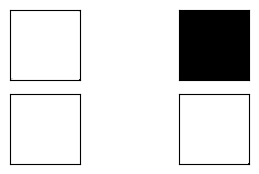

In [53]:
# user defined context
ctx = torch.tensor([
    # hero, non-hero, food, spell, side-facing
    [1,0,0,0,0,0,0,0,0,0],  
    [0,1,0,0,0,0,0,0,0,0],    
    [0,0,1,0,0,0,0,0,0,0],
    [0,0,0,1,0,0,0,0,0,0],
    [0,0,0,0,1,0,0,0,0,0],
    [0,0,0,0,0,1,0,0,0,0],
    [0,0,0,0,0,0,1,0,0,0],
    [0,0,0,0,0,0,0,1,0,0],
    [0,0,0,0,0,0,0,0,1,0],
    [0,0,0,0,0,0,0,0,0,1]
]).float().to(device)
samples, _ = sample_ddpm_context(4)
show_images(samples)

In [ ]:
# mix of defined context
ctx = torch.tensor([
    [1,0,0,0,0,0,0,0,0,0],
    [0.9,0.1,0,0,0,0,0,0,0,0],
    [0.8,0.2,0,0,0,0,0,0,0,0],
    [0.7,0.3,0,0,0,0,0,0,0,0],
    [0.6,0.4,0,0,0,0,0,0,0,0],
    [0.5,0.5,0,0,0,0,0,0,0,0],
    [0.4,0.6,0,0,0,0,0,0,0,0],
    [0.3,0.7,0,0,0,0,0,0,0,0],
    [0.2,0.8,0,0,0,0,0,0,0,0],
    [0.1,0.9,0,0,0,0,0,0,0,0],
    [0,1,0,0,0,0,0,0,0,0],
]).float().to(device)

samples, _ = sample_ddpm_context(ctx.shape[0], ctx)
show_images(samples)

In [ ]:
# user defined context
ctx = torch.tensor([
    # hero, non-hero, food, spell, side-facing
    [1,0,0,0,0,0,0,0,0,0],  
    [0,1,0,0,0,0,0,0,0,0],    
    [0,0,1,0,0,0,0,0,0,0],
    [0,0,0,1,0,0,0,0,0,0],
    [0,0,0,0,1,0,0,0,0,0],
    [0,0,0,0,0,1,0,0,0,0],
    [0,0,0,0,0,0,1,0,0,0],
    [0,0,0,0,0,0,0,1,0,0],
    [0,0,0,0,0,0,0,0,1,0],
    [0,0,0,0,0,0,0,0,0,1]
]).float().to(device)
samples, _ = sample_ddim_context(ctx.shape[0], ctx)
show_images(samples)

In [ ]:
# mix of defined context
ctx = torch.tensor([
    [1,0,0,0,0,0,0,0,0,0],
    [0.9,0.1,0,0,0,0,0,0,0,0],
    [0.8,0.2,0,0,0,0,0,0,0,0],
    [0.7,0.3,0,0,0,0,0,0,0,0],
    [0.6,0.4,0,0,0,0,0,0,0,0],
    [0.5,0.5,0,0,0,0,0,0,0,0],
    [0.4,0.6,0,0,0,0,0,0,0,0],
    [0.3,0.7,0,0,0,0,0,0,0,0],
    [0.2,0.8,0,0,0,0,0,0,0,0],
    [0.1,0.9,0,0,0,0,0,0,0,0],
    [0,1,0,0,0,0,0,0,0,0],
]).float().to(device)

samples, _ = sample_ddim_context(ctx.shape[0], ctx)
show_images(samples)

In [ ]:
import os
nn_model.train()
guide_w = 0.3
loss_values_2=[]
for ep in range(n_epoch):
    optim.param_groups[0]['lr'] = lrate*(1-ep/n_epoch)
    pbar = tqdm(dataloader, mininterval = 2)
    for x, c in pbar:
        optim.zero_grad()
        x=x.to(device)
        c=c.to(device)
        c=make_encoding(c)
    #print(c.shape)
        context_mask = torch.bernoulli(torch.zeros(c.shape[0]) + 0.9).to(device)
        
    #print(c.shape)
        noise = torch.randn_like(x)
        t = torch.randint(1, timesteps + 1, (x.shape[0],))
        x_pert = perturb_input(x, t, noise).to(device)
        pred_noise_2 = nn_model(x_pert, t/timesteps, c=None)
        pred_noise_1 = nn_model(x_pert, t/timesteps, c)
        pred_noise_final = eps = (1+guide_w)*pred_noise_1 - guide_w*pred_noise_2
        loss = F.mse_loss(pred_noise_final, noise)
        loss_values_2.append(loss)
        loss.backward()
        optim.step()
    

In [ ]:
loss_values_2 = torch.tensor(loss_values_2).cpu()
plt.plot(np.array(loss_values_2)

In [ ]:
# user defined context
ctx = torch.tensor([
    # hero, non-hero, food, spell, side-facing
    [1,0,0,0,0,0,0,0,0,0],  
    [0,1,0,0,0,0,0,0,0,0],    
    [0,0,1,0,0,0,0,0,0,0],
    [0,0,0,1,0,0,0,0,0,0],
    [0,0,0,0,1,0,0,0,0,0],
    [0,0,0,0,0,1,0,0,0,0],
    [0,0,0,0,0,0,1,0,0,0],
    [0,0,0,0,0,0,0,1,0,0],
    [0,0,0,0,0,0,0,0,1,0],
    [0,0,0,0,0,0,0,0,0,1]
]).float().to(device)
samples, _ = sample_ddpm_context(ctx.shape[0], ctx)
show_images(samples)

In [ ]:
# mix of defined context
ctx = torch.tensor([
    [1,0,0,0,0,0,0,0,0,0],
    [0.9,0.1,0,0,0,0,0,0,0,0],
    [0.8,0.2,0,0,0,0,0,0,0,0],
    [0.7,0.3,0,0,0,0,0,0,0,0],
    [0.6,0.4,0,0,0,0,0,0,0,0],
    [0.5,0.5,0,0,0,0,0,0,0,0],
    [0.4,0.6,0,0,0,0,0,0,0,0],
    [0.3,0.7,0,0,0,0,0,0,0,0],
    [0.2,0.8,0,0,0,0,0,0,0,0],
    [0.1,0.9,0,0,0,0,0,0,0,0],
    [0,1,0,0,0,0,0,0,0,0],
]).float().to(device)

samples, _ = sample_ddpm_context(ctx.shape[0], ctx)
show_images(samples)

In [ ]:
# user defined context
ctx = torch.tensor([
    # hero, non-hero, food, spell, side-facing
    [1,0,0,0,0,0,0,0,0,0],  
    [0,1,0,0,0,0,0,0,0,0],    
    [0,0,1,0,0,0,0,0,0,0],
    [0,0,0,1,0,0,0,0,0,0],
    [0,0,0,0,1,0,0,0,0,0],
    [0,0,0,0,0,1,0,0,0,0],
    [0,0,0,0,0,0,1,0,0,0],
    [0,0,0,0,0,0,0,1,0,0],
    [0,0,0,0,0,0,0,0,1,0],
    [0,0,0,0,0,0,0,0,0,1]
]).float().to(device)
samples, _ = sample_ddim_context(ctx.shape[0], ctx)
show_images(samples)

In [ ]:
# mix of defined context
ctx = torch.tensor([
    [1,0,0,0,0,0,0,0,0,0],
    [0.9,0.1,0,0,0,0,0,0,0,0],
    [0.8,0.2,0,0,0,0,0,0,0,0],
    [0.7,0.3,0,0,0,0,0,0,0,0],
    [0.6,0.4,0,0,0,0,0,0,0,0],
    [0.5,0.5,0,0,0,0,0,0,0,0],
    [0.4,0.6,0,0,0,0,0,0,0,0],
    [0.3,0.7,0,0,0,0,0,0,0,0],
    [0.2,0.8,0,0,0,0,0,0,0,0],
    [0.1,0.9,0,0,0,0,0,0,0,0],
    [0,1,0,0,0,0,0,0,0,0],
]).float().to(device)

samples, _ = sample_ddim_context(ctx.shape[0], ctx)
show_images(samples)

In [ ]:
# mix of defined context
ctx = torch.tensor([
    [1,0,0,0,0,0,0,0,0,0],
    [0.9,0.1,0,0,0,0,0,0,0,0],
    [0.8,0.2,0,0,0,0,0,0,0,0],
    [0.7,0.3,0,0,0,0,0,0,0,0],
    [0.6,0.4,0,0,0,0,0,0,0,0],
    [0.5,0.5,0,0,0,0,0,0,0,0],
    [0.4,0.6,0,0,0,0,0,0,0,0],
    [0.3,0.7,0,0,0,0,0,0,0,0],
    [0.2,0.8,0,0,0,0,0,0,0,0],
    [0.1,0.9,0,0,0,0,0,0,0,0],
    [0,1,0,0,0,0,0,0,0,0],
]).float().to(device)

samples, _ = sample_ddim_context(ctx.shape[0], None)
show_images(samples)

In [ ]:
# visualize samples with randomly selected context
plt.clf()
ctx = torch.tensor([
    # hero, non-hero, food, spell, side-facing
    [1,0,0,0,0,0,0,0,0,0],  
    [0,1,0,0,0,0,0,0,0,0],    
    [0,0,1,0,0,0,0,0,0,0],
    [0,0,0,1,0,0,0,0,0,0],
    [0,0,0,0,1,0,0,0,0,0],
    [0,0,0,0,0,1,0,0,0,0],
    [0,0,0,0,0,0,1,0,0,0],
    [0,0,0,0,0,0,0,1,0,0],
    [0,0,0,0,0,0,0,0,1,0],
    [0,0,0,0,0,0,0,0,0,1]
]).float().to(device)
samples, _ = sample_ddpm_context(ctx.shape[0], ctx)
#animation_ddpm_context = plot_sample(intermediate,32,4,save_dir, "ani_run", None, save=False)
#HTML(animation_ddpm_context.to_jshtml())